# How to balance a multiclass dataset in Python
Imbalanced datasets may often produce poor performance when running a Machine Learning model, although, in some cases the evaluation metrics produce good results. This can be due to the fact that the model is good at predicting the majority class, but it has poor performance while predicting the minority class. Since the evaluation metrics calculate the average value between the majority and minority classes, the final perfomance looks ok.

By majority class I mean the most represented class in the dataset, while by minority class I mean the less represented class in the dataset. In other words, for the majority class there are more samples than for the minority class. In this case, the dataset is imbalanced.

In most cases balancing improves the model performance, although this is not always true.

In this tutorial I deal with multiclass datasets. A multiclass dataset is a dataset where the number of output classes is greater than two. I propose two strategies to balance a multiclass dataset:
* pipeline undersampling and oversampling
* play with class weights.

## Load Dataset
Firstly, I load the dataset as a `pandas` dataframe. I exploit the [Glass Dataset](https://raw.githubusercontent.com/jbrownlee/Datasets/master/glass.csv) and [their names](https://raw.githubusercontent.com/jbrownlee/Datasets/master/glass.names). This dataset describes the chemical properties of glass. More details can be found [at this link](https://machinelearningmastery.com/multi-class-imbalanced-classification/).

In [3]:
import pandas as pd

df = pd.read_csv('glass.csv')
df.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,target
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


The dataset is composed of 214 samples and 7 classes.

In [8]:
df.shape

(214, 10)

## Prepare Data
I build two variables, `X` and `y` containing the input features and the output classes, respectively. In order to do so, I calculate the input features and I store them into a variable called `features`.

In [4]:
features = []
for feature in df.columns:
    if feature != 'target':
        features.append(feature)
features

['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe']

In [6]:
X = df[features]
y = df['target']

I split the dataset into two parts: training and test sets by exploiting the `train_test_split()` function, provided by the `sklearn` library. I set the test set size to `0.2` (i.e. 20% of the whole dataset).

In [282]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

Now I calculate the number of samples for each target class in the training set. I exploit the `value_counts()` function. I note that the dataset is imbalanced.

Balancing is applied only to the training set.

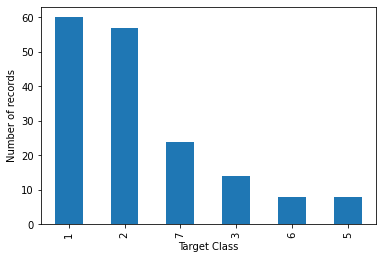

In [285]:
import matplotlib.pyplot as plt

count = y_train.value_counts()
count.plot.bar()
plt.ylabel('Number of records')
plt.xlabel('Target Class')
plt.show()

## Build the imbalanced model
Before balancing the training set, I calculate the performance of the model with imbalanced data. I exploit a `KNeighborsClassifier` for my tests. I also import other useful functions from the `scikitplot` library, to plot the ROC and precision recall curves. In detail, firstly I build the model, then I fit with the training set and finally I calculate the perfomance of the model through the `predict_proba()` function applied to the test set. 

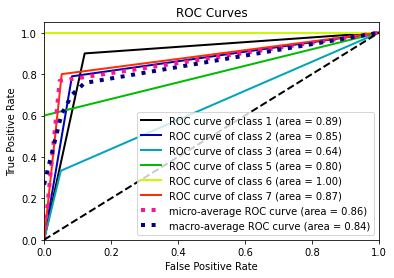

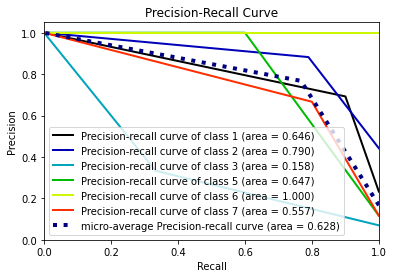

In [304]:
from sklearn.neighbors import KNeighborsClassifier
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall

model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_score = model.predict_proba(X_test)
y_pred = model.predict(X_test)

# Plot metrics 
plot_roc(y_test, y_score)
plt.show()
    
plot_precision_recall(y_test, y_score)
plt.show()

## Pipeline undersampling and oversampling

The first strategy involves the creation of a pipeline, which undersamples the majority classes and oversamples the minority classes. The point here is to define a threshold which splits majority and minority classes, as well as the number of desired samples for each class. In this specific example we set the threshold equal to the number of desired samples for each class. 

One possible solution could be to set the threshold to the median value of the number of samples in the classes. Thus I can set the threshold to 19 and consider a majority class a class with a number of samples greater than the threshold. Similarly, a minority class is a class with a number of samples less than the threshold.

I calculate the median and I convert it to integer.

In [287]:
import numpy as np
n_samples = count.median().astype(np.int64)
n_samples

19

Now I can undersample the most represented classes. Firstly, I suppress warnings.

In [288]:
import warnings
warnings.filterwarnings('ignore')

Then, I define a utility function, which receives as input the dataset, the threshold (`n_samples`) and the involved classes (`majority` or `minority`). This function returns a `dict` which contains the number of desired samples for each class belonging to the involved classes.

In [298]:
def sampling_strategy(X,y,n_samples, t='majority'):
    target_classes = ''
    if t == 'majority':
        target_classes = y.value_counts() > n_samples
    elif t == 'minority':
        target_classes = y.value_counts() < n_samples
    tc = target_classes[target_classes == True].index
    #target_classes_all = y.value_counts().index
    sampling_strategy = {}
    for target in tc:
        sampling_strategy[target] = n_samples
    return sampling_strategy

Now I perform undersampling of the majority classes.

In [299]:
from imblearn.under_sampling import ClusterCentroids
under_sampler = ClusterCentroids(sampling_strategy=sampling_strategy(X_train,y_train,n_samples,t='majority'))
X_under, y_under = under_sampler.fit_resample(X_train, y_train)

I note that the number of records in the majority classes have been set to `n_samples`.

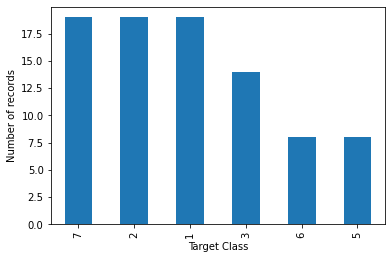

In [307]:
count = y_under.value_counts()
count.plot.bar()
plt.ylabel('Number of records')
plt.xlabel('Target Class')
plt.show()

Then I oversample the less represented classes.

In [292]:
from imblearn.over_sampling import SMOTE
over_sampler = SMOTE(sampling_strategy=sampling_strategy(X_under, y_under,n_samples, t='minority'),k_neighbors=2)
X_bal, y_bal = over_sampler.fit_resample(X_under, y_under)

Eventually I have a balanced dataset.

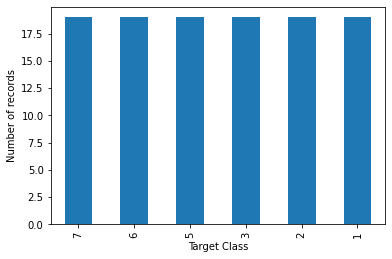

In [308]:
count = y_bal.value_counts()
count.plot.bar()
plt.ylabel('Number of records')
plt.xlabel('Target Class')
plt.show()

I train the model on the new balanced dataset and I note that the ROC curve improves, while the precision recall curve seems to decrease. However, looking at the class 3, in the original model the precision and recall were lower than in the balanced model. This means that the model now is able to predict better the minority classes.

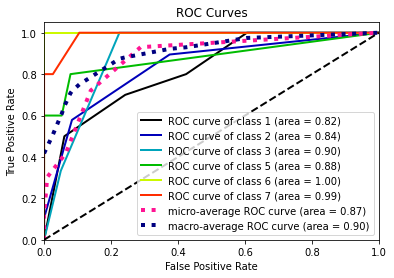

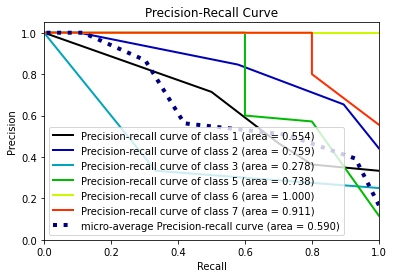

In [305]:
model = KNeighborsClassifier()
model.fit(X_bal, y_bal)
y_score = model.predict_proba(X_test)

y_pred = model.predict(X_test)

# Plot metrics 
plot_roc(y_test, y_score)
plt.show()
    
plot_precision_recall(y_test, y_score)
plt.show()

## Play with class weights
An alternative to balancing is to specify class weights in the original dataset while building the model. This permits the algorithm to give more importance to minority classes. Class weights can be calculated through the [class_weight()](https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html) function of the `sklearn.utils` library. 

In [277]:
from sklearn.utils import class_weight

classes = np.unique(y_train)
cw = class_weight.compute_class_weight('balanced', classes, y_train)
weights = dict(zip(classes,cw))

Now I can provide the class weights as input to a classifier, such as a `DecisionTreeClassifier`, and calculate the performance of the model.

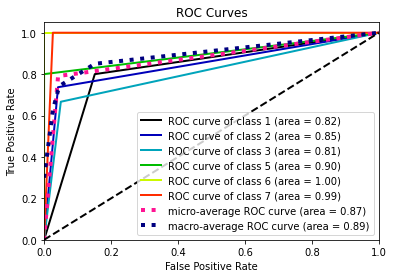

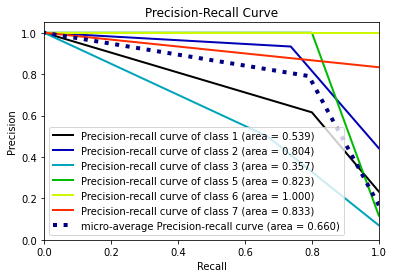

In [306]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(class_weight=weights)
model.fit(X_train, y_train)
y_score = model.predict_proba(X_test)

y_pred = model.predict(X_test)

# Plot metrics 
plot_roc(y_test, y_score)
plt.show()
    
plot_precision_recall(y_test, y_score)
plt.show()